In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from transformers import BertTokenizer, BertModel
import torch

In [ ]:
!pwd

/content


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the symptoms from the second file
with open('drive/My Drive/Projects/LSE-Symptomatology/Dataset/symptom_related_lexicon.txt', 'r') as file:
    symptoms_text = file.read()

In [ ]:
# Preprocess symptoms (lowercase, strip, and remove specific terms)
symptoms_list = [symptom.lower().strip() for symptom in symptoms_text.split(',')]
symptoms_list = [symptom for symptom in symptoms_list if "pcos" not in symptom.lower()]
symptoms_list = [symptom for symptom in symptoms_list if "none" not in symptom.lower()]

In [ ]:
print(f"Number of symptoms after cleaning: {len(symptoms_list)}")

Number of symptoms after cleaning: 30370


In [ ]:
# Load the BioBERT model

with open('BioBERT.txt', 'r') as f:
    model_name = f.read().strip()
biobert_model = SentenceTransformer(model_name)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.32k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/610 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/433M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/546 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# Generate embeddings
print("Generating BioBERT embeddings...")
symptoms_embeddings_biobert = biobert_model.encode(symptoms_list)

# Normalize embeddings for better clustering performance
normalized_embeddings_biobert = normalize(symptoms_embeddings_biobert, axis=1)

Generating BioBERT embeddings...


In [ ]:
# Calculate Inertia for Elbow Method
def calculate_inertia(data_matrix, min_clusters, max_clusters):


    inertia_values = []
    k_values = list(range(min_clusters, max_clusters + 1))

    for k in tqdm(k_values, desc="Calculating inertia for k"):
        kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
        kmeans.fit(data_matrix)
        inertia_values.append(kmeans.inertia_)

    return k_values, inertia_values

In [ ]:
# range of clusters to analyze
min_k = 5
max_k = 200

In [ ]:
print("Calculating inertia values...")
k_values, inertia_values = calculate_inertia(normalized_embeddings_biobert, min_k, max_k)

Calculating inertia values...


Calculating inertia for k: 100%|██████████| 196/196 [20:40<00:00,  6.33s/it]


In [ ]:
elbow_results = pd.DataFrame({
    "k": k_values,
    "Inertia": inertia_values
})


In [ ]:
elbow_results['Inertia_Change'] = elbow_results['Inertia'].diff()

In [ ]:
output_file_path = "drive/My Drive/Projects/LSE-Symptomatology/Data/rate_of_change_inertia.csv"


elbow_results.to_csv(output_file_path, index=False)

print(f"Updated data with rate of change (first derivative) saved to: {output_file_path}")


In [ ]:
elbow_results = pd.read_csv('drive/My Drive/Projects/LSE-Symptomatology/Data/rate_of_change_inertia.csv')

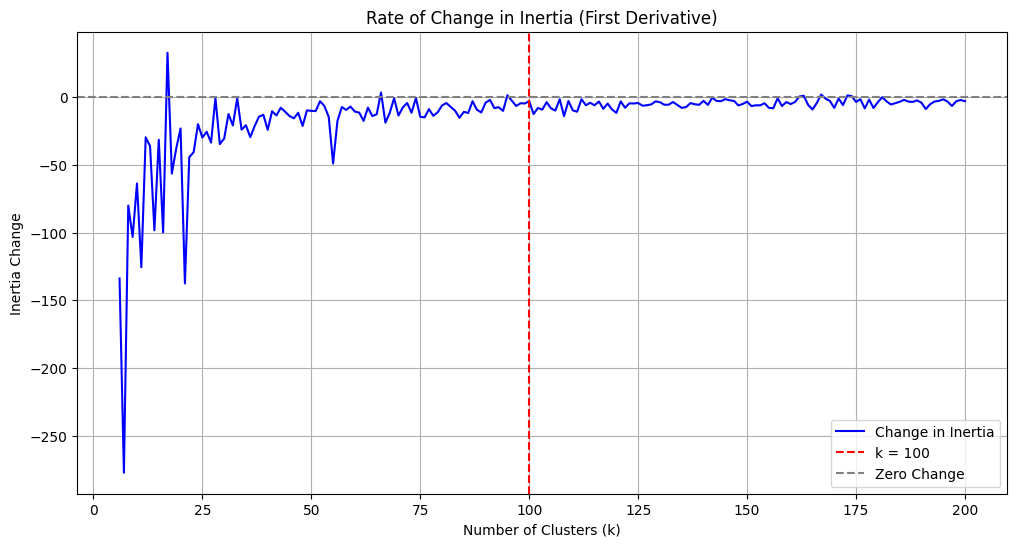

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(elbow_results['k'], elbow_results['Inertia_Change'], linestyle='-', color='blue', label='Change in Inertia')
plt.axvline(x=100, color='r', linestyle='--', label='k = 100')
plt.axhline(y=0, color='gray', linestyle='--', label='Zero Change')
plt.title('Rate of Change in Inertia (First Derivative)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('BioBERT')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Optionally save the plot
plt.savefig("elbow_method.svg", format='svg')
print("Elbow method plot saved as 'elbow_method.svg'.")